# STATS507 - Final Project

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
# Shuffle the imported data, drop the resultant features (Capacitance) for training and test samples.  
# Keep the resultant features (Capacitance) as Y for training samples and test samples.
elec_data = pd.read_csv('nanoelectrodes_capacitance_samples.csv')
elec_test = pd.read_csv('nanoelectrodes_capacitance_test.csv')
elec_data_shuffle = elec_data.iloc[np.random.permutation(len(elec_data))]
X_train = elec_data_shuffle.drop('Capacitance ($\mu F / cm^2$)', axis = 1)
Y_train = elec_data_shuffle['Capacitance ($\mu F / cm^2$)']
X_test = elec_test.drop('Capacitance ($\mu F / cm^2$)', axis = 1)
Y_test = elec_test['Capacitance ($\mu F / cm^2$)']

# Check the training samples are shuffled, and make sure we do not drop other features. 
X_train.head()

,Surface_Area ($m^2/g$),Defect_Ratio,Doped_Nitrogen_Percentage,Doped_Oxygen_Percentage,Doped_Sulfur_Percentage,Current_Density ($A/g$),Electrolyte_Concentration $[M]$,H9_Factor ($mL/g$),T5_Factor ($mL/g$),Doped_Zinc_Percentage,Doped_Flourine_Percentage,Doped_Carbon_Percentage
3,149.32,1.02,1.24,15.45,3.03,0.3,6.0,16.322920,9.179250,69.495872,35.124313,62.494312
65,966.00,1.06,1.62,5.96,0.48,5.0,6.0,97.774097,28.921629,24.052600,27.421912,42.283361
507,1109.00,1.43,4.20,22.10,1.30,5.0,6.0,111.574925,28.735090,49.923306,39.323186,37.180117
368,710.00,1.35,1.10,18.80,1.30,20.0,6.0,73.570837,104.872797,54.505378,48.229769,48.548997
301,1122.50,0.85,4.20,5.70,1.30,5.0,6.0,117.846340,27.395501,58.368119,32.791275,31.926115


### Subtask 1 - Train the Single Decision Tree Regression Model

In [7]:
# Step 1: define the splitting function based on any input feature and splitting threshold
def split_samples(X, y, column, value):
    """
    Key idea: Return the split of data based on the splitting threshold of column-th feature
    Arguments:
        column: the column we want to apply splitting.
        value: splitting threshold.
    Returns:
       tuples of ndarray after splitting
    """
    left_mask = (X[:, column] < value)
    # Using the binary masks `left_mask`, we split X, y.
    # Split the samples to the left if corresbonding X value is smaller. 
    X_l, y_l = X[left_mask, :], y[left_mask] 
    X_r, y_r = X[~left_mask, :], y[~left_mask] 
    return (X_l, y_l), (X_r, y_r)

Here is the loss function

$$
\min_{j, s} \left[ \sum_{x^{i} \in R_1(j, s)} (y^{i} - \bar{y}_{R_1})^2 + \sum_{x^{i} \in R_2(j, s)} (y^{i} - \bar{y}_{R_2})^2 \right]
$$

$$
\bar{y}_{R_1} = \frac{1}{N_{R_1}} \sum_{i=1}^{N} I(x_j^{i} < s) \cdot y^{i}
$$

$$
\bar{y}_{R_2} = \frac{1}{N_{R_2}} \sum_{i=1}^{N} I(x_j^{i} \geq s) \cdot y^{i}
$$

In [13]:
# Step 2: define the optimal threshold of splitting 
def  cost_split_value(X, y,column):
    """
    Key idea: Compute loss, then minimzie the loss to find the optimal threshold for a giving feature. 
    Arguments:
        column: the column of the feature for calculating. 0 <= column < D
    Returns:
        Two floats including the minimized cost and the corresponding splitting threshold.
    """

    # directly choosing splitting threshold from the data appeared in the target column. 
    unique_vals = np.unique(X[:, column])
    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."
    # initialize the cost and threshold.
    cost_val, threshold = np.inf, None
    # split the values of i-th feature and calculate the cost
    for value in unique_vals:
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, column, value)
        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
        # find the cost based on the loss function
        new_cost = np.sum(np.square(y_l-np.mean(y_l))) + np.sum(np.square(y_r - np.mean(y_r)))

        # update current cost and splitting threshold if there exist a better splitting value
        if new_cost < cost_val:
              cost_val, threshold = new_cost, value

    return cost_val, threshold

# Step 3: once find the optimal threshold, define function to find the best feature to do splitting at each stage.
def cost_split(X, y):
    """
    Key idea: Choose the best feature to split based on the same loss function.
    Returns:
        Integer and float indicating the optimal feature (in column index) and splitting threshold.
    """

    min_cost = np.inf
    split_column = None
    split_val = np.nan

    for column in range(12):
        # skip column if samples are not seperable by that column i.e. not enough distinct value for splitting.
        if len(np.unique(X[:, column])) < 2:
            continue
        current_cost, current_split_val = cost_split_value(X, y, column)  

        if current_cost < min_cost: 

            min_cost = current_cost 
            split_column = column
            split_val = current_split_val
            
    return split_column, split_val

In [ ]:
# Step 4: build the decision tree, the function will be run enumerately baed on new splitted data until reach maximum depth and minimum samples on leafs
def build_tree(X, y, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """
    Key idea: Build the decision tree according to the data.
    Arguments:
        feature_names: the name of features in the original dataset.
        depth: current depth for this node (i.e. how many splits occured now).
    Returns:
        A dictionary denoting the decision tree. Each node has seven attributes:
          1. 'feature_name': The column name.
          2. 'feature_index': The column index.
          3. 'value': The splitting threshold.
          4. 'left': Enumerate function, indicating sub-tree on the left.
          5. 'right' Enumerate function, indicating sub-tree on the right.
    """
    # return the terminal condition, when maximum depth reached, or samples on termnical nodes is not sufficient. 
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'predict_value': np.mean(y)}

    split_index, split_val = cost_split(X, y)  
    # return mean if there is no further split.
    if split_index is None:
        return {'predict_value': np.mean(y)}
    # split samples (X, y) given column and split-value.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val) 

    # output the result, using enumerate function, set the predict_value = None by default. 
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'predict_value': None,
        'left': build_tree(X_l, y_l, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

# Step 5: Integrate the functions before then output the decision tree, converting to numpy.
def train(X, y):
    """
    Key idea: Build the decision tree according to the training data.
    """

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    
    return build_tree(X, y, feature_names, depth=1)

In [36]:
# From here we already finished the training process for single decision tree. Now we start to fit the model on test samples.
# Step 6: Focusing on single data point, we allocate the datapoint to the tree, also using enumerate function for different branch. 
def classify(tree, x):
    """
    Key idea: Allocate a single sample with the trained single decision tree model.
    Arguments:
        x: single datapoint, including all features.     
    """
    if tree['predict_value'] is not None:
        return tree['predict_value']

    else:
        if x[tree['feature_index']] < tree['value']:
            # go to left branch
            return classify(tree['left'], x)
        else:
            # go to right branch
            return classify(tree['right'], x)

# Step 7: Apply the single datapoint prediction function to the entire test datasets. 
def predict(tree, X):
    """
    Key idea: Predict classification results for the entire X_test.    
    Returns:
        an numpy ndarray including predicted testing sample labels.
    """
    if len(X.shape) == 1:
        return classify(tree, X)
    else:
        return np.array([classify(tree, x) for x in X])

In [37]:
# Step 8: Finally define a function to evaluate the performance of models. Using 2 metrics MSE and R suqare. 
# We should expect a lower MSE and cloer to 1 R square. 
def tree_score(tree, X_test, y_test):
    """
    Key idea: Evaluate the single decision tree model by MSE and R square.
    Arguments:
        tree: trained model.
    Returns:
        r square and MSE of the trained model. 
    """
    y_pred = predict(tree, X_test)
    y_mean = np.mean(y_test)
    tss = np.sum((y_test - y_mean) ** 2)
    rss = np.sum((y_test - y_pred) ** 2)
    r_squared = 1 - (rss / tss)

    return r_squared, np.mean((y_test - y_pred) ** 2)

In [40]:
tree = train(X_train,Y_train)
print('Training accuracy:', tree_score(tree, X_train.to_numpy(), Y_train.to_numpy()))
print('Test accuracy:', tree_score(tree, X_test.to_numpy(),Y_test.to_numpy()))

Training accuracy: (0.7503640060081044, 1654.4051506951573)
Test accuracy: (0.4896216113769648, 3369.5671069811715)


### Subtask 2 - Train the Random Forest Model (Inherit the Same Structure From Subtask 1)

As we know, there is serious overfitting problems in the single decision tree regression model. By using less (not all) features in each tree and apply more trees leading to the random forest model. By training multiple trees (with different subsets of features) then averaging the predictions from all trees, we are expected to let the random forest model **reducing overfitting** and **more accurate and robust** than a single decision tree. Also it might have better performance when dealing with outliers. 

In [ ]:
# Step 1: Revise some functions used in single decision tree model.
# The main point is to add new variable "n_features" to create subsets used in training the model
def cost_split_rf(n_features, X, y):
    """
    Key idea: Choose the best feature from the size n features subset to split based on the same loss function.
    Returns:
        Integer and float indicating the optimal feature (in column index) and splitting threshold.
    """

    # randomly select subset from all feature spaces. 
    columns = np.random.choice(X.shape[1], n_features, replace=False)
    # Since we no longer take all features by default, we need to remain the information of minimum loss. 
    min_cost, split_column, split_val = np.inf, 0, 0

    for column in columns:
        # skip column if there is no sufficient values for splitting. 
        if len(np.unique(X[:, column])) < 2:
            continue 
        # search for the best splitting value for the given column.
        current_cost, val = cost_split_value(X, y, column)  
        if current_cost < min_cost:
            min_cost, split_column, split_val = current_cost, column, val

    return min_cost, split_column, split_val

def build_tree_rf(n_features, X, y, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """
    Key idea: Build the decision tree for random forest according to the data.
    Arguments:
        feature_names: the name of features in the original dataset.
        depth: current depth for this node (i.e. how many splits occured now).
    Returns:
        A dictionary denoting the decision tree. Each node has seven attributes:
          1. 'feature_name': The column name.
          2. 'feature_index': The column index.
          3. 'value': The splitting threshold.
          4. 'left': Enumerate function, indicating sub-tree on the left.
          5. 'right' Enumerate function, indicating sub-tree on the right.
    """
    # return the terminal condition, when maximum depth reached, or samples on termnical nodes is not sufficient.
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'predict_value': np.mean(y)}
    else:
        cost, split_index, split_val = cost_split_rf(n_features, X, y)  
    # If no valid split at this node, use the mean.
        if cost == np.inf:
            return {'predict_value': np.mean(y)}
    # Same as the single decision tree model, enumerate the code
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val) 
        return {
            'feature_name': feature_names[split_index],
            'feature_index': split_index,
            'value': split_val,
            'predict_value': None,
            'left': build_tree_rf(n_features,X_l, y_l, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [42]:
# Step 2: Train the random forest model. Notice that since random forest model requires multiple trees,
# we sample the training datapoints with replacement in original size (N). 
def train_rf(B, n_features, X, y, max_depth=10, min_samples_leaf=10):
    """
    Key idea: train the random forest model, add parameter B denoting number of trees. 
    Argumentss:
        B: number of decision trees.
        n_features: number of features used in training each tree. 
    """
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, feature_names, 1, max_depth, min_samples_leaf)
        trees.append(tree)

    return trees

def predict_rf(rf, X):
    """
    Key idea: give the prediction generated by random forest model. 
    Argumentss:
        rf: A trained random forest through train_rf function.
    Returns:
        an numpy ndarray including predicted testing sample labels.
    """
    if len(X.shape) == 1:
        # if we only have one sample
        return sum([classify(tree, X) for tree in rf]) / len([classify(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([[classify(tree, x) for tree in rf] for x in X]).mean(axis = 1)

### Subtask 3 - Using Cross-Validation (5-Fold) Method To Optimize Hyperparameters

In [ ]:
# Step 1: Similar to single decision tree model, we evalute the model by MSE and R square. 
# Here we use tree_score_rf function to help us choosing hyperparameters including number of trees, max_depth and min_samples_leaf.
def tree_score_rf(rf, X_test, y_test):
    """
    Key idea: Evaluate the random forest model by MSE and R square.
    Arguments:
        rf: trained random forest.
    Returns:
        r square and MSE of the trained model. 
    """
    y_pred = predict_rf(rf, X_test)
    y_mean = np.mean(y_test)
    tss = np.sum((y_test - y_mean) ** 2)
    rss = np.sum((y_test - y_pred) ** 2)
    r_squared = 1 - (rss / tss)

    return r_squared, np.mean((y_test - y_pred) ** 2)

In [ ]:
# Step 2: Find the 5-fold index, then compute MSE for different parameters. 
def cross_validation_MSE(B, X_train, y_train, folds, max_depth=10, min_samples_leaf=10):
    """
    Key idea: Compute the average MSE in given folds of input parameters.
    Arguments:
        B: Number of trees in the random forest.
        max_depth: maximum splits.
        min_sample_leafs: minimum samples on each terminal node. 
    Returns:
        Float indicating the average MSE of input parameters. 
    """
    mses = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        X_train_i = X_train.iloc[train_indexes, :]
        y_train_i = y_train.iloc[train_indexes]
        X_val_i = X_train.iloc[val_indexes, :] 
        y_val_i = y_train.iloc[val_indexes] 
        n_features = 4
        rf = train_rf(B, n_features, X_train_i, y_train_i, max_depth, min_samples_leaf)
        mses.append(tree_score_rf(rf, X_val_i.to_numpy(), y_val_i.to_numpy())[1])

    return sum(mses) / len(mses)

In [ ]:
# Step 3: Optimize number of trees.
folds_indexes_1 = np.array_split(np.arange(len(Y_train)), 5)
mse_b = []
for B in np.arange(10,50,3):
    mse_b.append(cross_validation_MSE(B, X_train, Y_train, folds_indexes_1))

The Minimum MSE is 3307.2365792652163 with 25 trees.


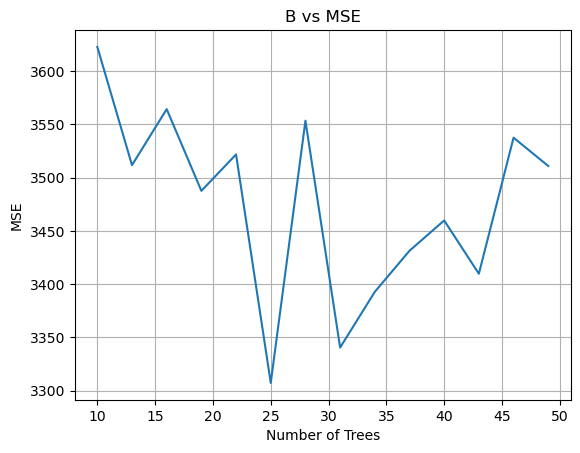

In [ ]:
# visualize and print the optimal number of trees
b_list = range(10,50,3)
plt.plot(b_list, mse_b)
plt.xlabel("Number of Trees")
plt.ylabel("MSE")
plt.title("B vs MSE")
plt.grid()

print(f"The Minimum MSE is {min(mse_b)} with {b_list[mse_b.index(min(mse_b))]} trees.")


In [56]:
# Step 4: Optimize other two hyperparameters (max_depth and min_samples_leaf)
n_features = 4
# Now we fix B, using results from step 3. 
B = b_list[mse_b.index(min(mse_b))]
max_depth_range = range(5,30,5)
# we want to keep at least 2 samples on each terminal node to avoid overfitting. 
min_samples_leaf_range = range(2,10,2)

def choose_best_hyper(B, X_train, y_train, folds, max_depth_range, min_samples_leaf_range):
    """
    Key idea: Record the MSE of different max_depth and min_samples_leaf
    Arguments:
        B: Number of trees in the random forest.
        max_depth: maximum splits.
        min_sample_leafs: minimum samples on each terminal node. 
    Returns:
        intergers of optimal max_depth and min_samples_leaf 
    """
    # initialize the score matrix
    scores = np.zeros((len(max_depth_range),len(min_samples_leaf_range)))
    for i, d in enumerate(max_depth_range):
        for j, l in enumerate(min_samples_leaf_range):
            scores[i,j] = cross_validation_MSE(B, X_train, y_train, folds,  
                                                      max_depth=d,min_samples_leaf=l)
            #print(f'CV_MSE@max_depth = {d}, min_samples_leaf = {l} is {scores[i,j]}')

    # find the index of combination with minimum MSE
    best_hypermeter = np.unravel_index(np.argmin(scores), scores.shape)
    
    return max_depth_range[best_hypermeter[0]], min_samples_leaf_range[best_hypermeter[1]], scores


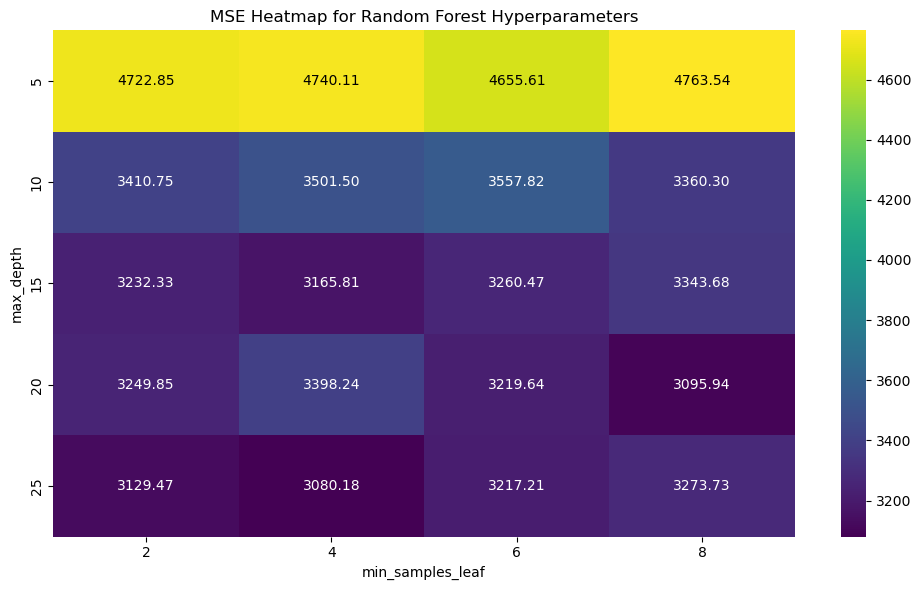

In [ ]:
# Visualize and choose the best combo of hyperparameters. 
best_md, best_msl, scores = choose_best_hyper(B, X_train, Y_train, 
                                    folds_indexes_1, max_depth_range, min_samples_leaf_range)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(scores, 
                cmap="viridis", 
                xticklabels=min_samples_leaf_range, 
                yticklabels=max_depth_range, 
                cbar=True)

ax.set_xlabel("min_samples_leaf")
ax.set_ylabel("max_depth")
ax.set_title("MSE Heatmap for Random Forest Hyperparameters")

cmap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=scores.min(), vmax=scores.max())

for i in range(scores.shape[0]):
    for j in range(scores.shape[1]):
        val = scores[i, j]
        color = cmap(norm(val))
        brightness = (color[0]*0.299 + color[1]*0.587 + color[2]*0.114)
        text_color = 'black' if brightness > 0.5 else 'white'
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}", 
                ha='center', va='center', color=text_color, fontsize=10)

plt.tight_layout()
plt.show()

print('best_max_depth, best_min_samples_leaf:', best_md, best_msl)

In [ ]:
# Verify the results on the test training set. 
rf = train_rf(B, 4, X_train, Y_train, best_md, best_msl)
print(f'For single DT model on test samples, the R^{2} is {tree_score(tree, X_test.to_numpy(),Y_test.to_numpy())[0]}, the MSE is {tree_score(tree, X_test.to_numpy(),Y_test.to_numpy())[1]}')
print(f'For random forest model on test samples with optimum hyperparameters, the R^{2} is {tree_score_rf(rf, X_test.to_numpy(), Y_test.to_numpy())[0]}, the MSE is {tree_score_rf(rf, X_test.to_numpy(), Y_test.to_numpy())[1]}')

For single DT model on test samples, the R^2 is 0.4896216113769648, the MSE is 3369.5671069811715
For random forest model on test samples with optimum hyperparameters, the R^2 is 0.5568403056636286, the MSE is 2925.7828357591065


### Subtask 4 - Using OOB on Random Forest Model to Decide the Importance of Each Features

Now the final subtask of Random Forest Model is to decide the importance of each features. From subtasks 1,2,3, we already train the optimal random forest model. Notice that Random Forest Model using multiple trained trees with reduced number of features (we use 4 features on each tree). Since for each tree we also draw samples with replacement, so if we can use the dropped samples and shuffle the values for a fixed feature, we are expected to enlarge the errors because that feature is not providing the right information. We then compare which feature lead to largest increase in the loss, and we can get the importance of features. This method is known as OOB (out-of-bag). 

In [66]:
# Step 1: Revise the train_rf_oob function to record the dropped samples at the same time. 
def train_rf_oob(B, n_features, X, y, max_depth=10, min_samples_leaf=10):
    """
    Key idea: we add another list containing indexes of dropped samples for each tree. 
    """

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []
    oob_samples_indices = []


    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        oob_indices = np.setdiff1d(np.arange(len(X)), sample)
        oob_samples_indices.append(oob_indices)
        tree = build_tree_rf(n_features, X_sample, y_sample, feature_names, depth=1, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
        trees.append(tree)

    return trees, oob_samples_indices

In [289]:
# Step 2: Compute the feature importance, by comparing the error increase by makeing a fixed feature not available. 
def calculate_feature_importance(trees, oob_samples_indices, X, y):
    N = X.shape[1]
    feature_importances = np.zeros(N)

    for feature_idx in range(N):
        errors = []

        for tree_idx, tree in enumerate(trees):
            oob_indices = oob_samples_indices[tree_idx]
            if len(oob_indices) == 0:
                continue
            # create sets of oob samples            
            X_oob = X[oob_indices, :]
            y_oob = y[oob_indices]
            # predict oob samples and calculate MSE
            y_pred_oob = predict(tree, X_oob)
            oob_error = np.mean((y_oob - y_pred_oob) ** 2)
            # shuffle the oob samples only in ith feature
            X_shuffled = X_oob.copy()
            np.random.shuffle(X_shuffled[:, feature_idx])
            y_shuffled = predict(tree, X_shuffled)
            shuffled_error = np.mean((y_oob - y_shuffled) ** 2)
            # append the difference between original oob error and shuffled oob error
            errors.append(shuffled_error - oob_error)
        feature_importances[feature_idx] = np.abs(sum(errors) / len(errors))
    # calculate the relative importance of all features in percentage
    feature_importances = (feature_importances / np.max(feature_importances))*100

    return feature_importances

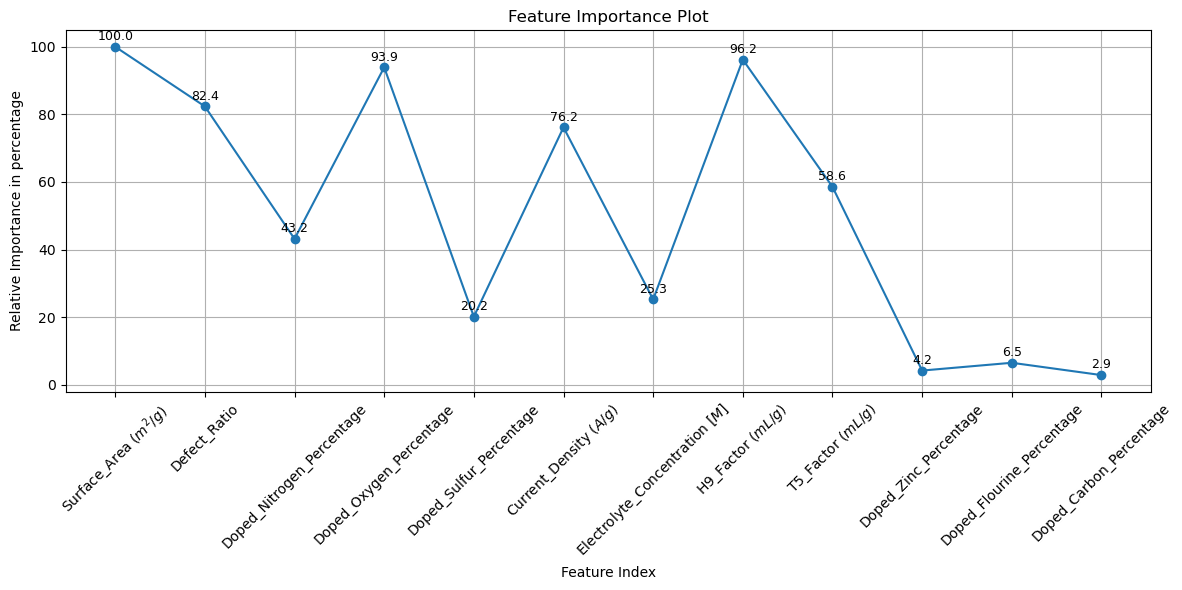

In [290]:
# visualize the results. 
oob_trees, oob_samples_indices = train_rf_oob(B, n_features, X_train, Y_train, best_md, best_msl)
feature_importance = calculate_feature_importance(oob_trees, oob_samples_indices, X_train.to_numpy(), Y_train.to_numpy())

plt.figure(figsize=(12, 6))
plt.plot(X_train.columns.to_list(), feature_importance, marker = 'o')
for i, (name, value) in enumerate(zip(X_train.columns.to_list(), feature_importance)):
    plt.text(i, value + 2, f"{value:.1f}", ha='center', fontsize=9)
plt.title('Feature Importance Plot')
plt.xlabel('Feature Index')
plt.ylabel('Relative Importance in percentage')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.grid()
plt.show()

### Subtask 5 - Construct MLP Model

In [292]:
# Step 1: Create function to standardise the data, MLP model requires centric data.
def standardise_cell(X):
  
  mu = np.mean(X, 0)
  sigma = np.std(X, 0)
  X_std = (X - mu) / sigma 
  
  return X_std

X_train_s = standardise_cell(X_train)
X_test_s = standardise_cell(X_test)

In [293]:
def dense(X, W, b):
    """
    Arguments:
        W: weight matrix.
        b: bias parameters
    Returns:
        a: output array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X]) 
    return a

In [294]:
# Step 2: Create activation function and gradient of activation function for MLP and SGD.
def tan_activation(a):
    """
    Key idea: Activation function containing arctan and log.
    Arguments:
        a: array of pre-activations
    Returns:
        h: array of post-activations
    """
    h = np.arctan(a)*(np.log(abs(a)+1))  
    return h

def grad_tan_activation(a):
    """
    Key idea: Gradient of activation function.
    Arguments:
        a: array of pre-activations
    Returns:
        grad: gradient array of post-activations
    """
    grad = np.log(abs(a)+1) / (a**2+1) + (a * np.arctan(a)) / (np.abs(a)*(np.abs(a)+1))
    return grad

In [295]:
# Step 3: Create class for MLP model. 
activation_table = {
    "tan": tan_activation,
    "identity": lambda x: x
}

grad_activation_table = {
    "tan": grad_tan_activation,
    "identity": lambda x: np.ones_like(x)
}

class MLP:
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """
        Key idea: Return the total number of parameters of weights and biases.
        """
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """
        Key idea: Return current number of MLP layers.
        """
        return len(self.layers)

    def layer_dim(self, index):
        """
        Key idea: Retrieve the dimensions of the MLP layer at given index.
        """
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim: The output dimension of the layer.
            out_dim: The input dimension of the layer.
            activation: The activation function name, set to identity as default.
        """
        # check if input matches output in dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # check if identity function is applied for the first layer.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations, use Identity function for the first layer."

        # store each layer as a dictionary
        self.layers.append({
            "index": len(self.layers),
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            "b": np.zeros(out_dim), 
            "activation": activation
        })

    def predict(self, X):
        """
        Key idea: Apply the forward pass on the input X and produce prediction.
        Arguments:
            X: Feature matrix.
        Returns:
            A tuple of the predictions and the computation graph.
        """
        if X.ndim == 1:
            X = X.reshape(1, -1)

        forward_pass = [{"index": 0, "a": X, "h": X}]
        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"]) 
            activation = activation_table[self.layers[k]["activation"]] 
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)}) 

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"]) 
        return y_hat, forward_pass

In [296]:
# Compute mse between true value and predicted value.
def mse_loss(y_true, y_pred):
    """
    Key idea: Compute MSE-loss
    Arguments:
        y_true: true values
        y_pred: predictions values
    Returns:
        loss: MSE-loss
    """
    assert y_true.size == y_pred.size, "Dimensions does not match"

    y_true = y_true.reshape(y_pred.shape)

    return np.mean((y_true - y_pred)**2, keepdims=True)

def grad_mse_loss(y_true, y_pred):
    """
    Key idea: Compute gradient of MSE-loss
    Arguments:
        y_true: true values, shape
        y_pred: prediction values, shape
    Returns:
        grad: an Numpy ndarray contains gradient of MSE-loss.
    """
    y_true = y_true.reshape(y_pred.shape)

    return 2.0 * (y_pred - y_true) / y_true.size

In [297]:
# Step 4: Backpropagation (optimizing the MLP model)
def backpropagate(layers, forward_pass, delta_output):
    """
    Key idea: apply the backpropagation algorithm to the MLP layers to compute the gradients 
    Arguments:
        layers: The MLP sequence of layers.
        forward_pass: The forward pass intermediate values foreach layer.
        delta_output: the partial derivative of the loss function w.r.t the predictions.
    Returns:
        The computed gradient using a structure symmetric the layers.

    """
    delta = delta_output
    assert len(layers) == len(forward_pass), "Number of layers do not match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    gradients = []
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."
        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."
        gradients.append({"W" : delta.T @ h, 
                          "b" : delta.sum(axis=0)}) 
        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])
        # Compute the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)]) 

    # Return ordered list matching the layers.
    return list(reversed(gradients))

In [298]:
def sgd_step(X, y, mlp, learning_rate = 5e-5):
    """
    Key idea: apply a stochastic gradient descent step
    Arguments:
        X: The input features array batch.
        y: The ground-truth of the batch.
        learning_rate: The learning rate multiplier for the update steps in SGD.
    Returns:
        The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X)
    # Compute the partial derivative of the loss w.r.t. to predictions.
    delta_output = grad_mse_loss(y, y_hat) 
    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output) 
    # mlp.layers and gradients are symmetric.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"] 
        b = layer["b"] - learning_rate * grad["b"] 
        updated_layers.append({"W": W, "b": b,
                               "activation": layer["activation"],
                               "index": layer["index"]})
    return updated_layers

In [299]:
def r2_score(y, y_hat):
    """
    Key idea: R^2 score to assess regression performance.
    """
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [300]:
from tqdm.notebook import tqdm

In [302]:
def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 5e-5,
        n_epochs=300, minibatchsize=50, seed=55):
    """
    Key idea: Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model 
    Arguments:
        X_train: The training data features in Numpy ndarray.
        y_train: The training data ground-truth in Numpy ndarray.
        X_test: The testing data features in Numpy ndarray.
        y_test: The testing data ground-truth in Numpy ndarray.
        mlp: The MLP model.
        learning_rate: The learning rate multiplier for the update steps in SGD.
        n_epochs: The number of training cycles.
        minibatchsize: The batch size used in each SGD step.
        seed: A seed for the RNG to ensure reproducibility across runtime sessions.
    """

    # get random number generator
    rng = np.random.default_rng(seed)
    n_iterations = int(len(y_train) / minibatchsize)
    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate) 
            # update weights and biases of MLP
            mlp.layers = updated_layers 
            
        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test

### Subtask 6 - Train and Visualize MLP Model

In [303]:
# Step 1: Build and optimize the MLP model
mlp = MLP(seed=2)
mlp.add_layer(12, 50)
mlp.add_layer(50, 50, "tan")
mlp.add_layer(50,50, "tan")
mlp.add_layer(50,50, "tan")
mlp.add_layer(50, 1, "tan")
print("Number of layers:", mlp.n_layers())
print("Number of trainable parameters:", mlp.n_parameters())

n_epochs = 300
mlp, losses_train, losses_test = sgd(X_train_s.to_numpy(), Y_train.to_numpy(), X_test_s.to_numpy(), Y_test.to_numpy(),
                                     mlp, learning_rate = 5e-5,
                                     n_epochs=n_epochs,
                                     minibatchsize=8)

Number of layers: 5
Number of trainable parameters: 8351


  0%|          | 0/300 [00:00<?, ?it/s]

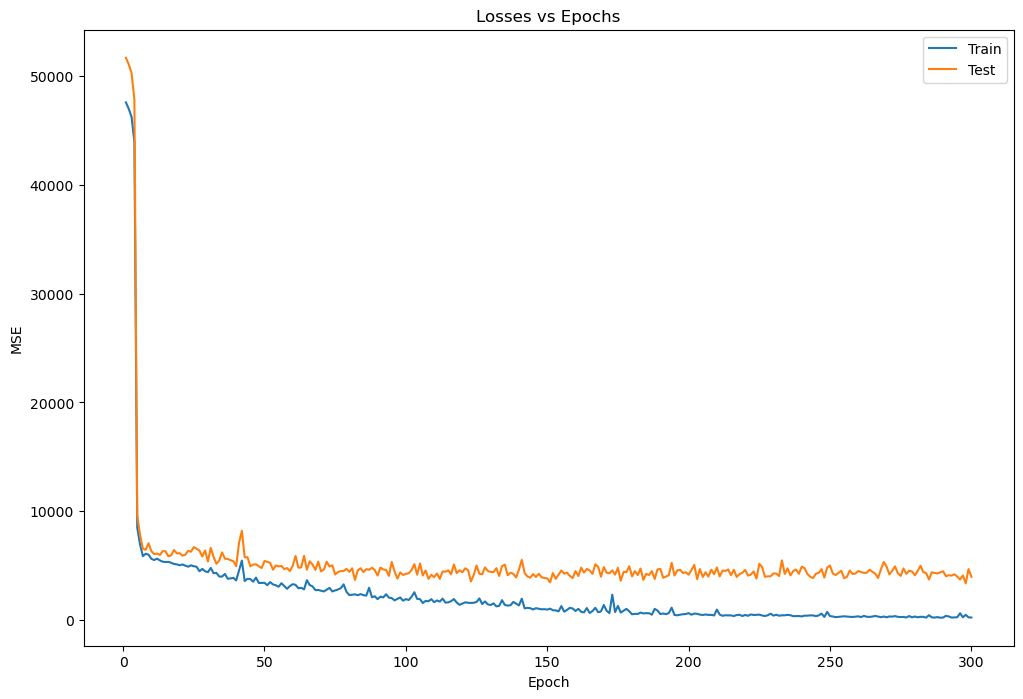

In [304]:
# visualize the losses process, check if the losses will converge. 
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.show()

In [305]:
# Step 2: Create quadratic term for orignial dataset, in this case, should be 2C12 + 12*2 = 90 features.
def quadratic_features(X):
    # create a dictionary to store new features, then concat to original dataframe
    quadratic_df = {}

    for i, featurei in enumerate(X.columns):
        
        quadratic_df[f'{featurei}^2'] = X[featurei] ** 2
        for featurej in X.columns[i + 1:]:
            quadratic_df[f'{featurei} * {featurej}'] = X[featurei] * X[featurej]

    # merge the original dataset with quadratic features
    X_quad = pd.concat([X, pd.DataFrame(quadratic_df)], axis=1)
    return X_quad

In [306]:
# generate quadratic vector
X_train_quad = quadratic_features(X_train)
X_test_quad = quadratic_features(X_test)

In [307]:
# standardise quadratic vector
X_train_quad_s = standardise_cell(X_train_quad)
X_test_quad_s = standardise_cell(X_test_quad)

In [308]:
# Step 3: Build and optimize the extended MLP model (including quadratic terms)
mlp_ext = MLP(seed=2)
mlp_ext.add_layer(90, 100)
mlp_ext.add_layer(100, 100, "tan")
mlp_ext.add_layer(100, 100, "tan")
mlp_ext.add_layer(100, 100, "tan")
mlp_ext.add_layer(100, 1, "tan")
print("Number of layers:", mlp_ext.n_layers())
print("Number of trainable parameters:", mlp_ext.n_parameters())

n_epochs = 300
mlp_ext, losses_train, losses_test = sgd(X_train_quad_s.to_numpy(), Y_train.to_numpy(), X_test_quad_s.to_numpy(), Y_test.to_numpy(),
                                     mlp_ext,learning_rate = 5e-5,
                                     n_epochs=n_epochs,
                                     minibatchsize=8)

Number of layers: 5
Number of trainable parameters: 39501


  0%|          | 0/300 [00:00<?, ?it/s]

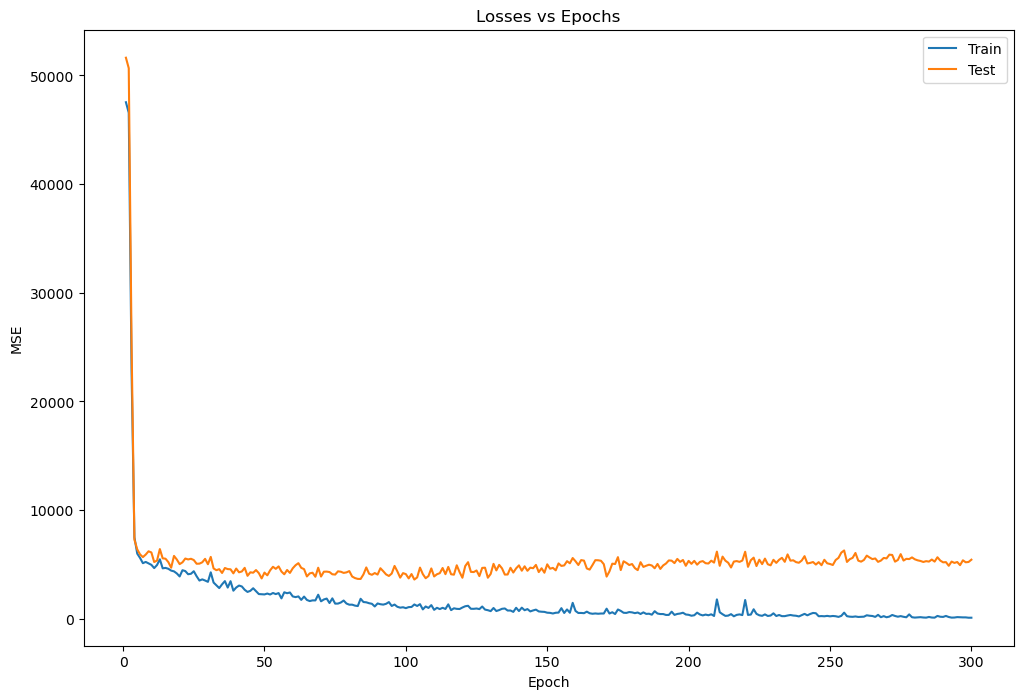

In [309]:
# visualize the losses process, check if the losses will converge. 
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.show()

We observe serious overfitting problems (huge drop in MSE and $R^2$) for MLP model including quadratic terms, thus we choose the original MLP model. 

In [ ]:
# choose original MLP model 
mlp = MLP(seed=2)
mlp.add_layer(12, 50)
mlp.add_layer(50, 50, "tan")
mlp.add_layer(50,50, "tan")
mlp.add_layer(50,50, "tan")
mlp.add_layer(50, 1, "tan")
print("Number of layers:", mlp.n_layers())
print("Number of trainable parameters:", mlp.n_parameters())

n_epochs = 300
mlp, losses_train, losses_test = sgd(X_train_s.to_numpy(), Y_train.to_numpy(), X_test_s.to_numpy(), Y_test.to_numpy(),
                                     mlp, learning_rate = 5e-5,
                                     n_epochs=n_epochs,
                                     minibatchsize=8)

Number of layers: 5
Number of trainable parameters: 8351


  0%|          | 0/300 [00:00<?, ?it/s]

In [311]:
# Step 4: Compute the feature importance by shuffling 1 feature at a time index by index.
original_loss = losses_test[-1].item()
features_loss_list = []

for f in range(12):
    loss_list = []
    for i in range(100):
        X_shuffled = X_test_s.copy()
        X_shuffled.iloc[:, f] = np.random.permutation(X_shuffled.iloc[:, f].values)
        y_hat, _ = mlp.predict(X_shuffled.to_numpy())
        new_loss = mse_loss(Y_test.to_numpy(), y_hat).squeeze()
        loss_list.append(new_loss)

    features_lost = (sum(loss_list) / len(loss_list)) - original_loss
    features_loss_list.append(features_lost.item())

features_importance_mlp = (np.array(features_loss_list) / max(features_loss_list))*100

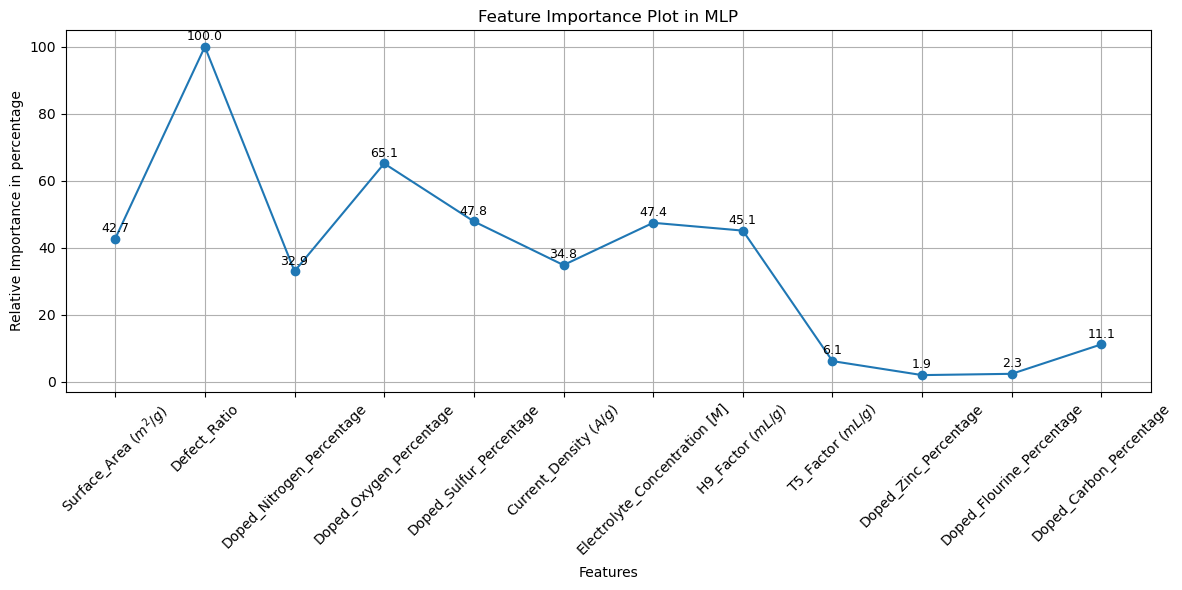

In [312]:
# Visualize the feature importance
plt.figure(figsize=(12, 6))
plt.plot(X_train.columns.to_list(), features_importance_mlp, marker = 'o')
for i, (name, value) in enumerate(zip(X_train.columns.to_list(), features_importance_mlp)):
    plt.text(i, value + 2, f"{value:.1f}", ha='center', fontsize=9)
plt.title('Feature Importance Plot in MLP')
plt.xlabel('Features')
plt.ylabel('Relative Importance in percentage')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.grid()
plt.show()